https://colab.research.google.com/drive/1gAuEaOMxxavIZDbA4BcmL0dbTHS3CtVz

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2019-10-02 13:15:24--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  15.9MB/s    in 0.3s    

2019-10-02 13:15:24 (15.9 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [2]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
import numpy as np
import pandas as pd

In [0]:
column_names = ['User', 'Movies', 'rating', 'timestamp']
ratings = pd.read_csv('/content/ml-100k/u.data', sep='\t', names=column_names)   # Path to downloaded file

In [5]:
ratings = ratings[ratings['rating']>3]
ratings = ratings.sort_values(by='timestamp')
ratings.reset_index(inplace=True)
ratings = ratings.drop(['index'],axis=1)
ratings.head()

,User,Movies,rating,timestamp
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843


In [6]:
user_movie_count = ratings.groupby('User').agg({'Movies':'nunique'}).reset_index()
user_movie_count.head()

,User,Movies
0,1,163
1,2,40
2,3,15
3,4,19
4,5,58


In [0]:
user_movie_count.columns = ['User','User_Movie_count']

In [8]:
ratings2 = ratings.merge(user_movie_count,on='User',how='inner')
ratings2.head()

,User,Movies,rating,timestamp,User_Movie_count
0,259,255,4,874724710,33
1,259,286,4,874724727,33
2,259,298,4,874724754,33
3,259,185,4,874724781,33
4,259,173,4,874724843,33


In [9]:
movie_count = ratings2[ratings2['User_Movie_count']>5]
movie_count = movie_count.sort_values('timestamp')
movie_count.reset_index(inplace=True)
movie_count = movie_count.drop(['index'],axis=1)
movie_count.head()

,User,Movies,rating,timestamp,User_Movie_count
0,259,255,4,874724710,33
1,259,286,4,874724727,33
2,259,298,4,874724754,33
3,259,185,4,874724781,33
4,259,173,4,874724843,33


In [0]:
ratings = movie_count
users = ratings.User.unique()
movies = ratings.Movies.unique()
userid2idx = {o:i for i,o in enumerate(users)}
moviesid2idx = {o:i for i,o in enumerate(movies)}
idx2userid = {i:o for i,o in enumerate(users)}
idx2moviesid = {i:o for i,o in enumerate(movies)}

In [11]:
l = list(moviesid2idx.keys())
print(len(l))
set([x for x in l if l.count(x) > 1])

1447


set()

In [12]:
ratings['Movies2'] = ratings.Movies.apply(lambda x: moviesid2idx[x])
ratings['User2'] = ratings.User.apply(lambda x: userid2idx[x])
ratings.describe()

,User,Movies,rating,timestamp,User_Movie_count,Movies2,User2
count,55341.000000,55341.000000,55341.000000,5.534100e+04,55341.000000,55341.000000,55341.000000
mean,458.344988,377.229035,4.382935,8.834536e+08,109.688206,365.887588,439.858116
std,268.035118,300.338391,0.486107,5.378800e+06,71.814662,318.413168,272.023599
min,1.000000,1.000000,4.000000,8.747247e+08,6.000000,0.000000,0.000000
25%,250.000000,159.000000,4.000000,8.794456e+08,49.000000,131.000000,200.000000
50%,439.000000,286.000000,4.000000,8.825669e+08,100.000000,262.000000,428.000000
75%,680.000000,527.000000,5.000000,8.882052e+08,150.000000,510.000000,672.000000
max,943.000000,1674.000000,5.000000,8.932866e+08,378.000000,1446.000000,933.000000


In [0]:
user_list = movie_count['User2'].unique()

In [14]:
x = []
y = []
for i in range(len(user_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  #print(total_user_movies.shape[0])
  for j in range(total_user_movies.shape[0]-6):
    x.append(total_user_movies.loc[j:(j+4),'Movies2'].tolist())
    y.append(total_user_movies.loc[(j+5),'Movies2'].tolist())

0
100
200
300
400
500
600
700
800
900


In [15]:
max(x)

[1446, 476, 427, 29, 1010]

In [0]:
src_vocab = ratings['Movies2'].nunique()
n_units = 32
src_timesteps = 5
tar_vocab = len(set(y))

In [17]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional

Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(Embedding(src_vocab, n_units, input_length=src_timesteps))
model.add((LSTM(100)))
model.add(Dense(1000,activation='relu'))
model.add(Dense(max(y)+1,activation='softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 32)             46304     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_2 (Dense)              (None, 1447)              1448447   
Total params: 1,648,951
Trainable params: 1,648,951
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical

In [20]:
max(y)

1446

In [0]:
y2 = to_categorical(y, num_classes = max(y)+1)

In [22]:
y2.shape

(49737, 1447)

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)

In [24]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['acc'])

In [0]:
trainX = np.array(x[:40000])
testX = np.array(x[40000:])
trainY = np.array(y2[:40000])
testY = np.array(y2[40000:])

In [26]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(40000, 5) (40000, 1447) (9737, 5) (9737, 1447)


In [27]:
model.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40000 samples, validate on 9737 samples
Epoch 1/5
40000/40000 [==============================] - 32s 795us/step - loss: 6.5860 - acc: 0.0069 - val_loss: 6.5376 - val_acc: 0.0085
Epoch 2/5
40000/40000 [==============================] - 26s 652us/step - loss: 6.4023 - acc: 0.0075 - val_loss: 6.5259 - val_acc: 0.0086
Epoch 3/5
40000/40000 [==============================] - 26s 655us/step - loss: 6.3730 - acc: 0.0079 - val_loss: 6.4608 - val_acc: 0.0092
Epoch 4/5
40000/40000 [==============================] - 26s 654us/step - loss: 6.2533 - acc: 0.0099 - val_loss: 6.2915 - val_acc: 0.0120
Epoch 5/5
40000/40000 [==============================] - 26s 659us/step - loss: 6.1191 - acc: 0.0107 - val_loss: 6.2000 - val_acc: 0.0118


In [28]:
np.argmax(reversed(np.argsort(model.predict(testX[0].reshape(1,5)),axis=1)==213))

0

In [0]:
pred = model.predict(testX)

In [30]:
np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))

99

In [0]:
count = 0
for i in range(testX.shape[0]):
  rank = np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))
  if rank<12:
    count+=1

In [32]:
count/testX.shape[0]

0.10311184142959844

In [33]:
historically_watched = []
x = []
y = []
for i in range(len(user_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  for j in range(total_user_movies.shape[0]-6):
    historically_watched.append(total_user_movies.loc[0:(j+4),'Movies2'].tolist())
    x.append(total_user_movies.loc[j:(j+4),'Movies2'].tolist())
    y.append(total_user_movies.loc[(j+5),'Movies2'].tolist())

0
100
200
300
400
500
600
700
800
900


In [0]:
test_hist = x[40000:]
test_historically_watched = historically_watched[40000:]

In [35]:
testX.shape

(9737, 5)

In [36]:
pred.shape

(9737, 1447)

In [37]:
len(test_hist)

9737

In [38]:
for j in range(pred.shape[0]):
  if(j%100==0):
    print(j)
  for i in range(pred.shape[1]):
    pred[j][i]= np.where(i in test_historically_watched[j], 0 , pred[j][i])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700


In [0]:
count = 0
for i in range(testX.shape[0]):
  rank = np.argmax(np.argsort(pred[i])[::-1]==np.argmax(testY[i]))
  if rank<12:
    count+=1

In [40]:
count/testX.shape[0]

0.13453835883742427

In [41]:
np.mean(pred[:,0])

0.0013303476

In [42]:
!pip install gensim

In [0]:
import gensim

In [0]:
movie_list = movie_count['Movies2'].unique()

In [0]:
user_list = movie_count['User2'].unique()

In [46]:
user_movies = []
for i in range(len(movie_list)):
  if(i%100 == 0):
    print(i)
  total_user_movies = movie_count[movie_count['Movies2']==movie_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  total_user_movies['User3'] = total_user_movies['User2'].astype(str)
  user_movies.append(total_user_movies['User3'].tolist())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [0]:
user_movies = []
for i in range(len(user_list)):
  total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
  total_user_movies.reset_index(inplace=True)
  total_user_movies = total_user_movies.drop(['index'],axis=1)
  total_user_movies['Movies3'] = total_user_movies['Movies2'].astype(str)
  user_movies.append(total_user_movies['Movies3'].tolist())

In [48]:
len(user_movies)

934

In [0]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(user_movies,size=100,window=5,min_count=5, iter = 500)

In [50]:
w2v_model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(1008, 100)

In [51]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_img_label = tsne_model.fit_transform(w2v_model.wv.syn0)
tsne_df = pd.DataFrame(tsne_img_label, columns=['x', 'y'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1008 samples in 0.004s...
[t-SNE] Computed neighbors for 1008 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1008
[t-SNE] Computed conditional probabilities for sample 1008 / 1008
[t-SNE] Mean sigma: 6.455657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 126.498222
[t-SNE] KL divergence after 1000 iterations: 2.229942


In [0]:
tsne_df['image_label'] = list(w2v_model.wv.vocab.keys())

In [54]:
tsne_df.head()

,x,y,image_label
0,3.626514,-1.835943,0
1,3.221222,-1.979085,1
2,3.836137,-1.852223,2
3,3.169300,-2.095436,3
4,-4.438925,-4.112025,4


In [57]:
idx2movie = pd.DataFrame([idx2moviesid.keys(), idx2moviesid.values()]).T
idx2movie.columns = ['image_label','movieId']
idx2movie.head()

,image_label,movieId
0,0,255
1,1,286
2,2,298
3,3,185
4,4,173


In [0]:
tsne_df['image_label'] = tsne_df['image_label'].astype(int)

In [59]:
tsne_df.head()

,x,y,image_label
0,3.626514,-1.835943,0
1,3.221222,-1.979085,1
2,3.836137,-1.852223,2
3,3.169300,-2.095436,3
4,-4.438925,-4.112025,4


In [60]:
tsne_df2 = pd.merge(tsne_df, idx2movie, on='image_label', how='right')
tsne_df2.head()

,x,y,image_label,movieId
0,3.626514,-1.835943,0,255
1,3.221222,-1.979085,1,286
2,3.836137,-1.852223,2,298
3,3.169300,-2.095436,3,185
4,-4.438925,-4.112025,4,173


In [65]:
cd ml-100k

/content/ml-100k


In [66]:
!ls

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
movies = pd.read_csv('/content/ml-100k/u.item', sep='|',encoding='latin1',header=None, engine='python')  # Path to movies file. May need to specify the filename here

In [0]:
tsne_df3 = pd.merge(tsne_df2, movies, left_on='movieId', right_on = 0, how='inner')

In [69]:
tsne_df3.head()

,x,y,image_label,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,3.626514,-1.835943,0,255,255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.221222,-1.979085,1,286,286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,3.836137,-1.852223,2,298,298,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,3.169300,-2.095436,3,185,185,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,-4.438925,-4.112025,4,173,173,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [71]:
tsne_df3.shape

(1447, 28)

In [0]:
tsne_df4 = tsne_df3.drop([2,3,4],axis=1)

In [0]:
tsne_df4.rename(columns={1:'movie_name'}, inplace=True)

In [74]:
tsne_df4.describe()

,x,y,image_label,movieId,0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,1008.000000,1008.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,-0.502731,0.447677,723.000000,755.094679,755.094679,0.000691,0.154803,0.090532,0.026952,0.078784,0.304768,0.064962,0.026952,0.422944,0.012440,0.014513,0.054596,0.038010,0.040083,0.155494,0.067035,0.155494,0.045612,0.016586
std,3.322841,3.812505,417.857232,452.835833,452.835833,0.026288,0.361842,0.287042,0.162000,0.269494,0.460468,0.246544,0.162000,0.494197,0.110875,0.119633,0.227268,0.191286,0.196222,0.362500,0.250169,0.362500,0.208713,0.127758
min,-7.975515,-7.783763,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.306313,-2.781320,361.500000,365.500000,365.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.426186,0.746419,723.000000,737.000000,737.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.270691,3.635440,1084.500000,1119.500000,1119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.417630,8.579293,1446.000000,1674.000000,1674.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
tsne_df4.shape

(1447, 25)

In [0]:
from sklearn.cluster import KMeans

In [0]:
tsne_df5 = tsne_df4.loc[~np.isnan(tsne_df4['x']),]

In [0]:
X = tsne_df5.loc[:,['x','y']]

In [79]:
inertia = []
for i in range(10):
  km = KMeans((i+1)*10)
  km.fit(X)
  inertia.append(km.inertia_)
  print(i)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Inertia')

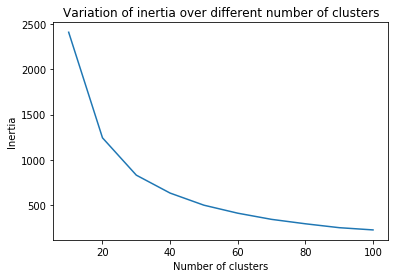

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot((np.arange(10)+1)*10,inertia)
plt.title('Variation of inertia over different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [81]:
km = KMeans(40)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [82]:
tsne_df5['cluster_label'] = km.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
tsne_df5[tsne_df5['cluster_label']==0].head()

,x,y,image_label,movieId,0,movie_name,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,cluster_label
37,-2.791745,-4.363646,18,121,121,Independence Day (ID4) (1996),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
45,-2.901590,-4.715369,366,9,9,Dead Man Walking (1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
50,-3.133323,-3.932948,245,410,410,Kingpin (1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,-2.267932,-4.536309,757,619,619,Extreme Measures (1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
57,-3.083512,-3.925447,110,826,826,"Phantom, The (1996)",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
movie_cluster_id = tsne_df5[['image_label','cluster_label']]

In [0]:
pred = model.predict(testX)

In [86]:
pred.shape

(9737, 1447)

In [87]:
for j in range(pred.shape[0]):
  if(j%1000==0):
    print(j)
  for i in range(pred.shape[1]):
    pred[j][i]= np.where(i in test_historically_watched[j], 0 , pred[j][i])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [88]:
pred.shape

(9737, 1447)

In [89]:
movie_cluster_id.head()

,image_label,cluster_label
0,0,4
1,1,27
2,2,4
3,3,27
4,4,37


In [90]:
list(movie_cluster_id['image_label'])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 33,
 299,
 224,
 120,
 27,
 175,
 187,
 292,
 123,
 112,
 303,
 1229,
 375,
 248,
 32,
 1227,
 17,
 353,
 305,
 570,
 13,
 14,
 15,
 16,
 18,
 78,
 79,
 80,
 109,
 730,
 401,
 113,
 366,
 195,
 365,
 242,
 540,
 245,
 806,
 398,
 642,
 757,
 249,
 106,
 110,
 101,
 640,
 251,
 807,
 349,
 264,
 28,
 351,
 76,
 157,
 211,
 322,
 266,
 192,
 614,
 135,
 261,
 118,
 50,
 121,
 443,
 341,
 281,
 57,
 137,
 282,
 128,
 183,
 30,
 209,
 213,
 39,
 144,
 348,
 267,
 625,
 158,
 318,
 153,
 181,
 308,
 1001,
 1225,
 1057,
 228,
 1050,
 484,
 1268,
 580,
 725,
 1145,
 1349,
 393,
 1002,
 779,
 373,
 1035,
 728,
 1260,
 830,
 23,
 1271,
 236,
 1234,
 222,
 390,
 1075,
 136,
 167,
 99,
 1007,
 1415,
 19,
 21,
 22,
 24,
 25,
 26,
 29,
 31,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 51,
 52,
 53,
 54,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 505,
 108,
 506

In [91]:
pred[0,list(movie_cluster_id['image_label'])]

array([2.1201055e-03, 1.6457058e-03, 0.0000000e+00, ..., 3.4450190e-05,
       2.1154237e-05, 6.7987385e-05], dtype=float32)

In [92]:
count = 0
for j in range(pred.shape[0]):
  if(j%500==0):
    print(j)
  t = movie_cluster_id.copy()
  t['pred']=pred[j,list(movie_cluster_id['image_label'])]
  t2= t.sort_values(by='pred',ascending=False).groupby('cluster_label').first().reset_index()
  #xx2 = t2.groupby('cluster_label').head(1).reset_index()
  t3 = t2.sort_values(by='pred',ascending=False).reset_index()
  final_top_preds = t3.loc[:11]['image_label'].values
  if (np.argmax(testY[j]) in final_top_preds):
    count+=1
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [93]:
count/testX.shape[0]

0.13104652356988805